<a href="https://colab.research.google.com/github/aidatak97/bachelor-thesis/blob/main/notebooks/introduction_to_statespace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

<a href="https://colab.research.google.com/github/AlexAndorra/pydata-berlin-statespace-models/blob/main/notebooks/introduction_to_statespace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we will learn about time series modeling.

In the broadest sense, a time series model is simply a model that explicitly includes time. "Including time", of course, can mean lots of things. For example, we might literally put time into the model as a feature. Calling our variable of interest $y_t$, we might say that $y_t$ follows a *deterministic trend*, or:

$$ y_t = \alpha + \beta t + \varepsilon_t $$

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install git+https://github.com/pymc-devs/pymc-extras.git@main
    !pip install nutpie
    !pip install watermark

import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

warnings.filterwarnings(action="ignore", category=UserWarning)

plt.rcParams.update(
    {
        "figure.figsize": (14, 4),
        "figure.dpi": 144,
        "axes.grid": True,
        "grid.linewidth": 0.5,
        "grid.linestyle": "--",
        "axes.spines.top": False,
        "axes.spines.bottom": False,
        "axes.spines.left": False,
        "axes.spines.right": False,
    }
)


SEED = sum(map(ord, "Intro to Statespace"))
rng = np.random.default_rng(SEED)

  Cloning https://github.com/pymc-devs/pymc-extras.git (to revision main) to /tmp/pip-req-build-fuct6gn7
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-devs/pymc-extras.git /tmp/pip-req-build-fuct6gn7
  Resolved https://github.com/pymc-devs/pymc-extras.git to commit d5f8f763a55c6eb680bfffa56def636571312ac1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.6/517.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for pymc-extras: filename=pymc_extras-0.4.1-py3-none-any.whl size=240800 sha256=1c4e04df1edfe8268bc5cf1c55cd320e74feda039b6de02757f3fe13fade7760
  Stored in directory: /tmp/pip-ephem-wheel-cache-qs_icd0p/wheels/67/09/d2/dcc949ac5209f95b364e3e1f8421adb41c4e57c086f50052c4
Successfully built pymc-extras
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [ ]:
coords = {"time": range(100)}
with pm.Model(coords=coords) as deterministic_trend:
    t = pm.Data("t", range(100), dims=["time"])
    alpha = pm.Normal("alpha", mu=3, sigma=1)
    beta = pm.HalfNormal("beta", sigma=0.1)
    mu = pm.Deterministic("mu", alpha + beta * t, dims=["time"])

    sigma = pm.Exponential("sigma", 1)
    y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, dims=["time"])
    prior = pm.sample_prior_predictive(draws=1, random_seed=rng)

Sampling: [alpha, beta, sigma, y_hat]


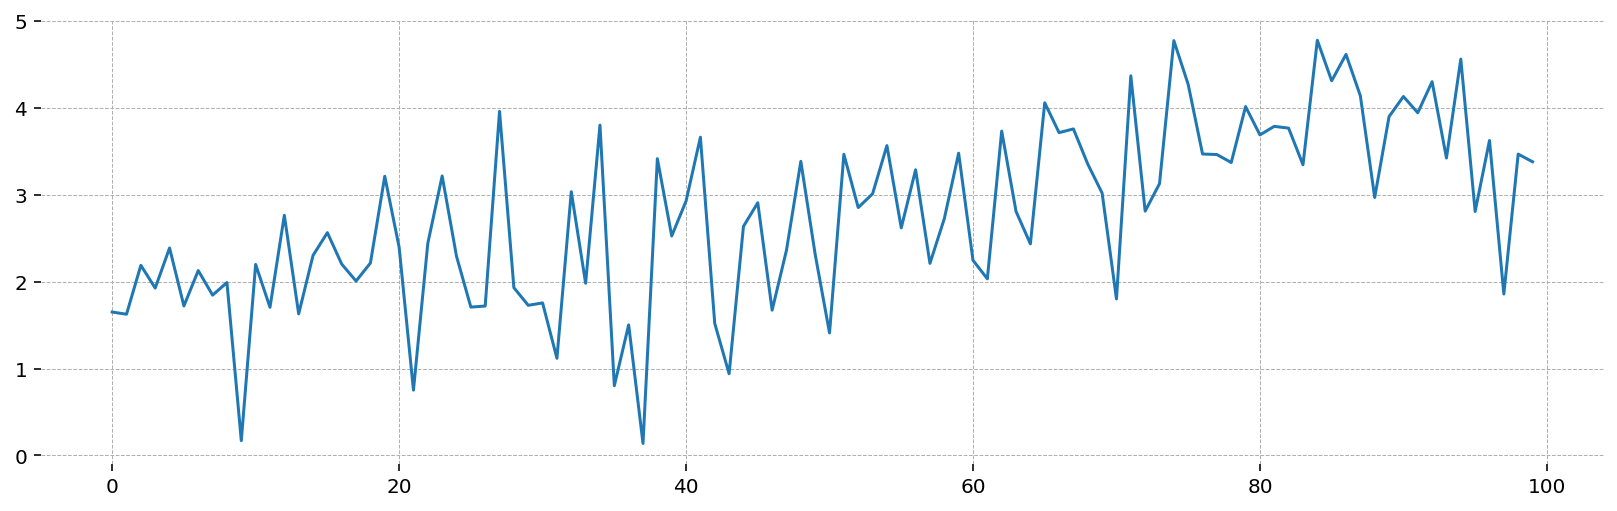

In [ ]:
data = prior.prior.y_hat.values.squeeze()
plt.plot(data);

In [ ]:
with pm.observe(
    deterministic_trend, {"y_hat": prior.prior.y_hat.values.squeeze()}
) as deterministic_trend_obs:
    idata = pm.sample(compile_kwargs={"mode": "NUMBA"}, random_seed=rng)
    idata = pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y_hat]


Output()

The types of things you want to do with a time series models are sometimes different from what is done with a "normal" model. For one, we want to be able to say something about the future. Time-as-feature models are attractive, because it is trivial to know the future values of the time variable: it marches forward. We can directly replace the training time with an out-of-sample time and generate forecasts.

In [ ]:
with deterministic_trend_obs:
    pm.set_data({"t": range(100, 120)}, coords={"time": range(100, 120)})
    forecast = pm.sample_posterior_predictive(
        idata, extend_inferencedata=False, predictions=True, random_seed=rng
    )

Sampling: [y_hat]


Output()

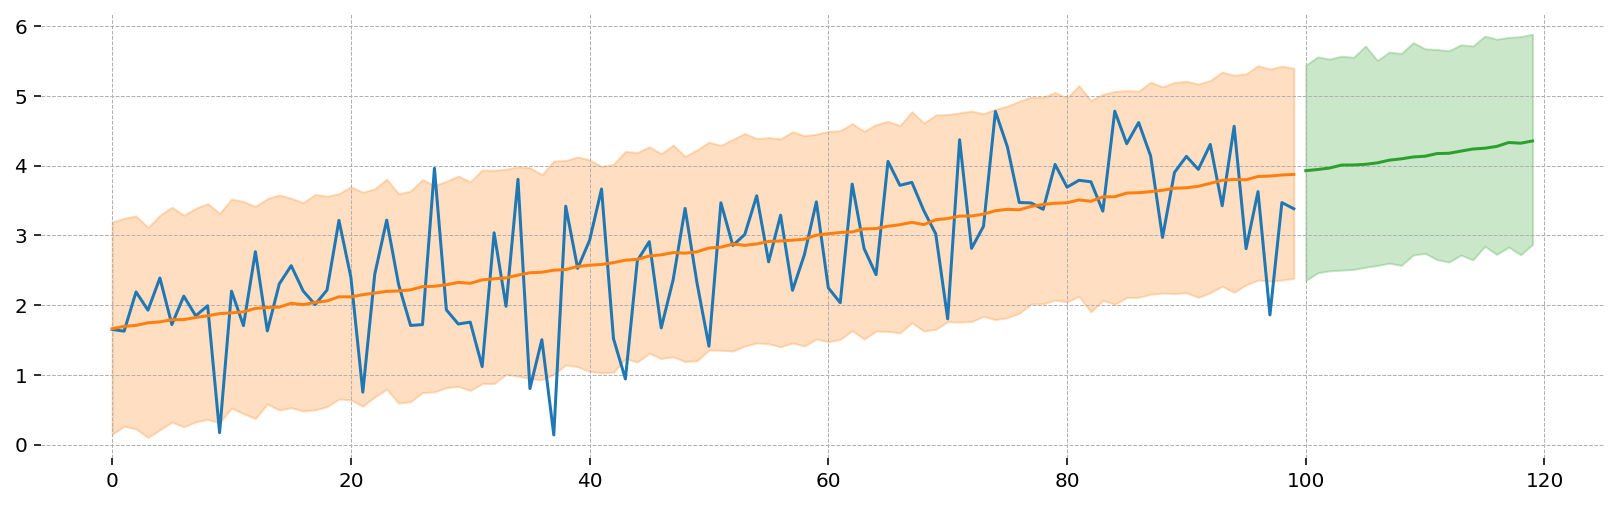

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
ax.plot(data)

mu = idata.posterior_predictive.y_hat.mean(dim=["chain", "draw"])
hdi = az.hdi(idata.posterior_predictive).y_hat

ax.plot(mu)
ax.fill_between(range(100), *hdi.values.T, color="tab:orange", alpha=0.25)

forecast_mu = forecast.predictions.y_hat.mean(dim=["chain", "draw"])
forecast_hdi = az.hdi(forecast.predictions).y_hat
ax.plot(range(100, 120), forecast_mu)
ax.fill_between(range(100, 120), *forecast_hdi.values.T, color="tab:green", alpha=0.25)
plt.show()

This example is extremely simple, but it can be extended in powerful ways by pumping time values of time through arbitrarily complex functions. Examples include the Prophet model, which transform the time counter into a time-varying trend and sinusoidal seasonal waves.

Gaussian Processes are another example -- these pump the time counter through a **kernel function**, and evaluates datapoints as "similar" or "different" based on their distance in the kernel space.

Time-as-feature models have a lot of advantages. At the end of the day, many of them are just basic linear projections (not GPs though). As such, they fit quickly, scale well, and can be trivially parallelized for minibatching and hardware acceleration.

That said, this tutorial is *not* about time-as-feature models.

# Thinking in Systems

If you've had some statistical training, you will *not* think about time-as-feature models when you close your eyes and picture a time series model. Instead, you'll probably think of the other class of time series models: **recursive models**.

Recursive models dispense with time per-se. Instead of tracking which timestep we're at using some function $y_t = f(t)$, we're instead going to write the system itself as a function of it's own history. That is, we are interested in the class of models:

$$ \begin{align} y_t &= g(y_{t-1}) \\ y_0 & \quad \text{given} \end{align}$$

The "game" of a time-series model is: tell me some initial condition $y_0$ and an update rule $g$, then we can "unroll" all of history.

The "Hello World" of time series models is probably an AR(1), which is written:

$$ y_t = \rho y_{t-1} $$

Let's write an AR(1) model in PyMC!

## A scanner darkly

Now, you might now that PyMC has an `pm.AR` distribution, which you could just use. But if you really want to get deep into the weeds, you're going to need to get to know the `scan` function.

`scan` is an differentiable loop. It's Pytensor's way of writing a recursive function. It seems complex at first, but it's really not that bad. The problem is that it has it's own vocabulary. Acutally, time series models have their own vocabulary too. We just have to push past all that.

`scan` asks you to provide an **inner function** that is recursively applied. This is what we called $g$ in the math above. It also asks you to classify the inputs to this inner functions into 3 groups:

- `sequences` are **non-recursive**. You know the entire, well, *sequence* at the start of the recursion, and you just want to feed in the values one at a time. In an AR(1) model, there are no sequences.
- `outputs_info` is a horrible name, but it refers to **recursive** inputs. At every step, the output of the inner function becomes the next input. In the AR(1) model, $y_0$ is an `outputs_info`
- `non_sequences` are... not sequences. They are passed into the inner function **exactly as-is**, every single time. In the AR(1) model, $rho$ is a `non_sequence`.

The final gotcha is that the **order** of these arguments matters! You **MUST** write your inner function with the signature:

```py
def inner_function(*sequences, *outputs_info, *non_sequences):
    ...
```

In [ ]:
def ar1_step(y_tm1, rho):
    return rho * y_tm1


with pm.Model(coords={"time": range(100)}) as ar1_model:
    rho = pm.Normal("rho", mu=0, sigma=1)
    y0 = pm.Normal("y0", mu=3, sigma=1)

    y_sequence, _ = pytensor.scan(
        fn=ar1_step, outputs_info=[y0], non_sequences=[rho], n_steps=99
    )
    y_hat = pm.Deterministic("y_hat", pt.join(0, y0[None], y_sequence), dims=["time"])


# Use pm.do to set rho = 0.95
with pm.do(ar1_model, {rho: 0.9}):
    prior = pm.sample_prior_predictive(draws=1, random_seed=rng)

Sampling: [y0]


Did you already know it was an exponential decay? For the motiviated and math-inclined among you, use the equation $y_t = \rho y_{t-1}$ to show that $y_t = \rho^t y_0$.

(Hint: use the fact that this equation holds for all $t$, so you also know how to write $y_{t-1}, y_{t-2}, \dots$ )

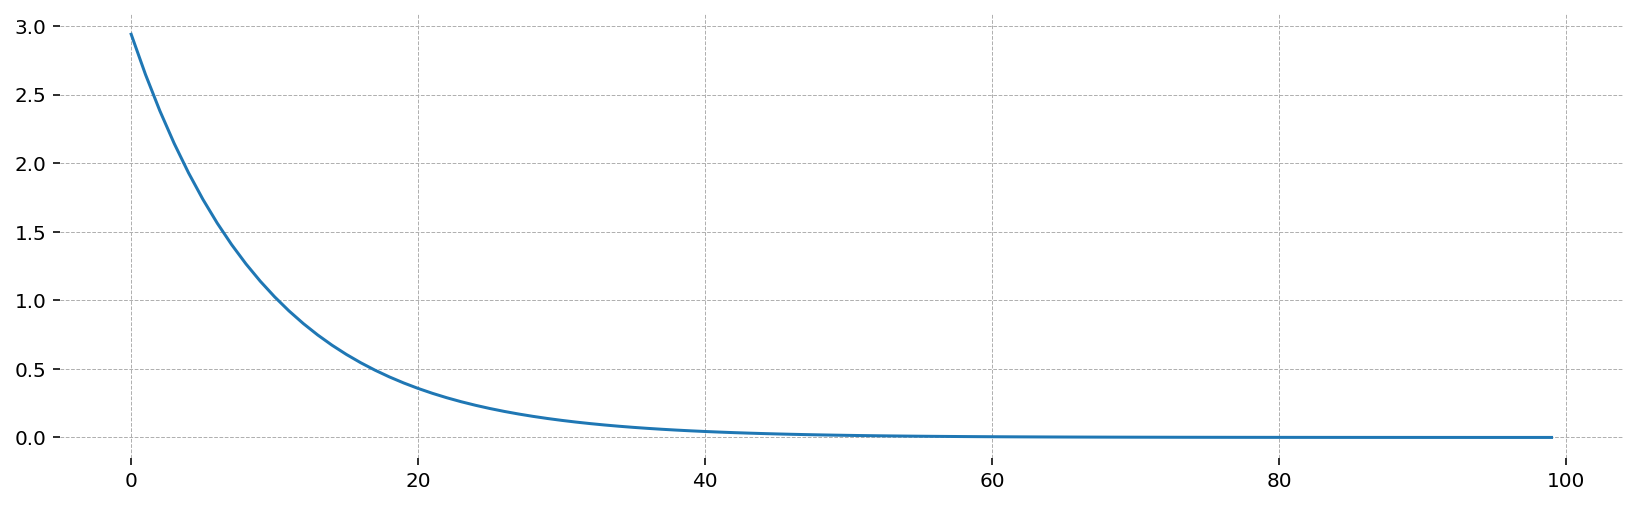

In [ ]:
data = prior.prior.y_hat.values.squeeze()
plt.plot(data);

The AR(1) model is worth studying because it gently introduces the idea of *stationarity*. Using `pm.do`, explore what happens given different values of $\rho$, including (`rho = -0.9` and `rho = 1.1`).

## The Daughter of Necessity

Our AR(1) model is, so far, pretty dull. To make it more interesting, we should bring in **stochastic innovations**. This will also kick off our vocabulary section, since statespace models are full of vocabulary.

An **innovation** is a random variable that *pushes around the system*. We want to distinguish between **innovations**, which are somehow "inside" the system, and **measurement error**, which is randomness associated without ability to *observe* the system. They're not the same, so we have to use language to distinguish them.

To introduce innvoations, we can put a random variable inside our `ar1_step` function. Innovations are typically mean zero with unknown variable. So our function now needs a non-sequence `sigma` input. Here's how it looks:

In [ ]:
from pymc.distributions.timeseries import rv_size_is_none
from pymc.pytensorf import collect_default_updates


def ar1_step(y_tm1, rho, sigma):
    innovation = pm.Normal.dist(mu=0, sigma=sigma)
    y_t = rho * y_tm1 + innovation

    return y_t, collect_default_updates([y_t])


def ar1_dist(y0, rho, sigma, size=None):
    if rv_size_is_none(size):
        n_steps = 100
    else:
        n_steps = size[0]

    y_sequence, _ = pytensor.scan(
        fn=ar1_step, non_sequences=[rho, sigma], outputs_info=[y0], n_steps=n_steps
    )

    return y_sequence


with pm.Model(coords={"time": range(100)}) as ar1_model:
    rho = pm.Normal("rho", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    y0 = pm.Normal("y0", mu=3, sigma=1)

    y_hat = pm.CustomDist("y_hat", y0, rho, sigma, dist=ar1_dist, dims=["time"])

There is a *lot* of boilerplate here. A lot of it is out of the scope of this tutorial -- I encourage you to check out [this example notebook](https://www.pymc.io/projects/examples/en/latest/time_series/Time_Series_Generative_Graph.html) that goes into much more detail about building custom time series models. The important details here are:


1. `pm.CustomDist` allows you to turn any *generative function with random variables* into a PyMC distribution that can be sampled. To do this, you have to use the `.dist` API.
2. Pytensor is 100% functional, and, by default, doesn't allow any side-effects from computation. That includes incrementing psudo-random number generators. To circumvent this, you have to trigger some special machinery using `collect_default_updates`.
3. I didn't want to hard-code `n_steps`, so I had to account for the case where the `size` variable is unknown. I had to provide the `size=None` argument because that's what `pm.CustomDist` expects.

If you're interested in how `pm.CustomDist` works, you can check out this [logp puzzle notebook](https://colab.research.google.com/github/ricardoV94/probability-puzzles/blob/main/puzzles.ipynb) by the one-and-only [Ricardo Vieria](http://github.com/ricardoV94).


**ANYWAY**, once that's all defined, we can sample the model:

In [ ]:
with pm.do(ar1_model, {"rho": 0.95}):
    prior = pm.sample_prior_predictive(draws=1, random_seed=rng)

data = prior.prior.y_hat.values.ravel()

Sampling: [sigma, y0, y_hat]


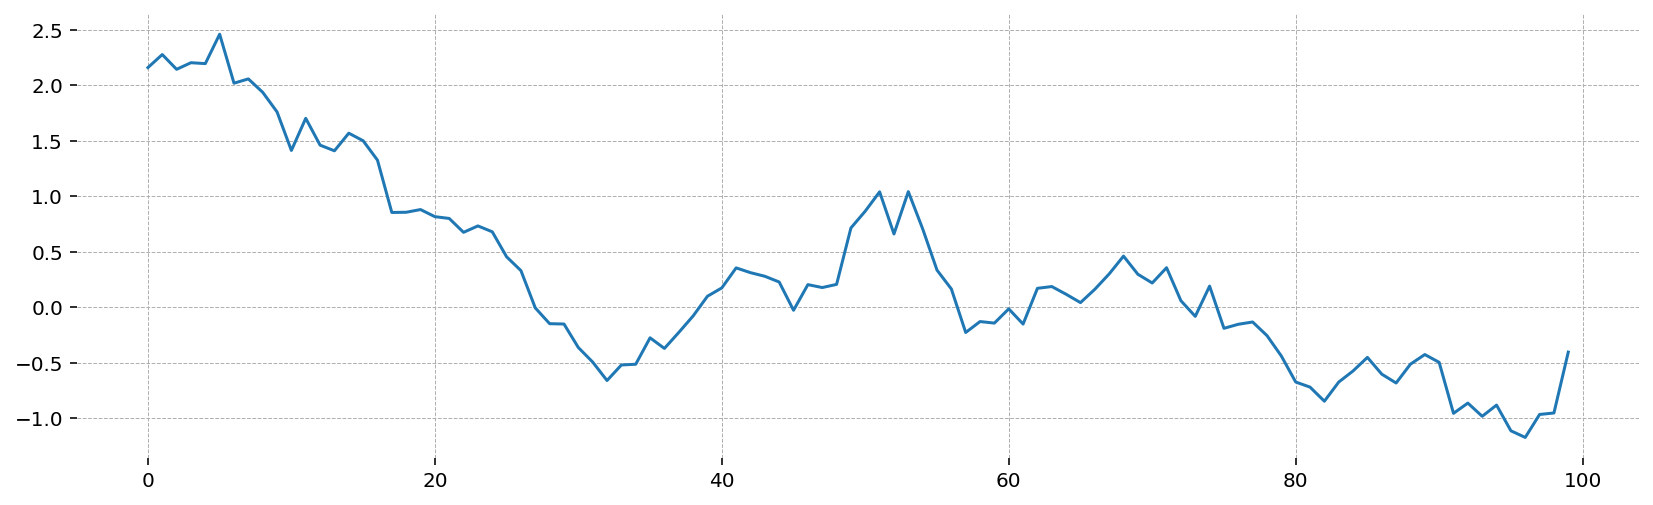

In [ ]:
plt.plot(data);

Then use our sample as observed data and solve the inverse problem, getting posterior and posterior predictive distributions.

In [ ]:
with pm.observe(ar1_model, {"y_hat": data}) as ar1_model_obs:
    idata = pm.sample(compile_kwargs={"mode": "NUMBA"})
    idata = pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma, y0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y_hat]


Output()

## Mamma Mia 🍝🧑‍🍳!

Let's see what we've got by looking at a **spaghetti plot**, which is just all the sampled **trajectories** (time series) we got from our posterior predictive.

You will be forgiven for thinking, "is this even fit"? Why do we have trajectories flying off into infinity? Let's trim away those and focus on just the ones closer to the data.

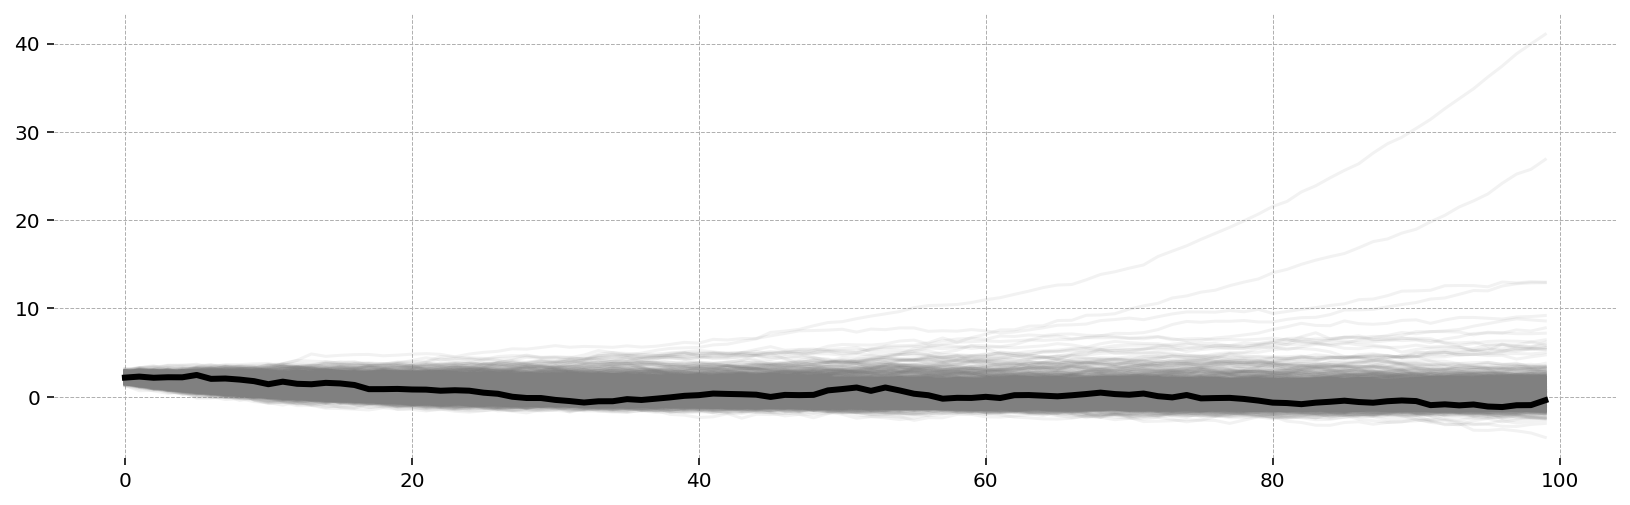

In [ ]:
fig, ax = plt.subplots()
ax.plot(data, c="k", lw=3, zorder=100)
ax.plot(
    idata.posterior_predictive.y_hat.stack(sample=["chain", "draw"]).values,
    color="0.5",
    alpha=0.1,
)
plt.show()

You will be forgiven for still thinking this is not fit. The mean doesn't really run through the data (although the data does seem to "wander" around the mean). The range of possible values seems too large at each timestep. Are we even taking the data into account?

Actually, we're not. We've stumbled onto an important distinction in recursive time series modeling, between a **conditional** and **unconditional** distribution.

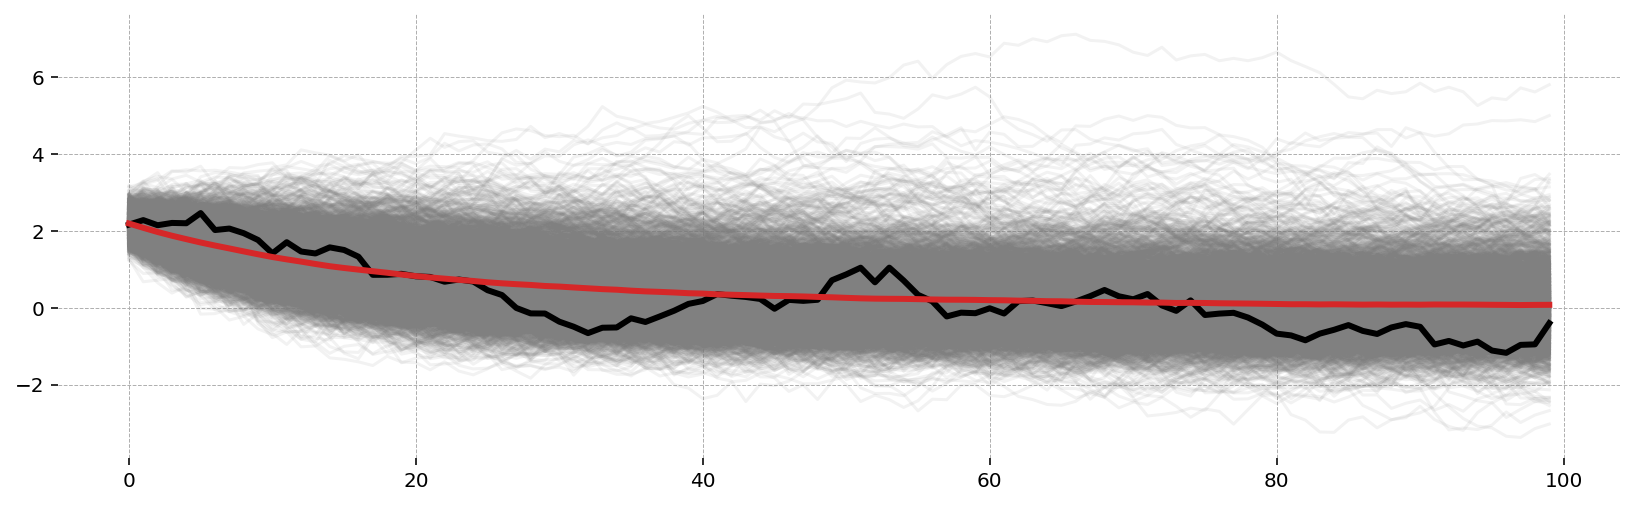

In [ ]:
fig, ax = plt.subplots()
ax.plot(data, c="k", lw=3, zorder=100)

stationary_mask = np.abs(idata.posterior.rho) < 1

ax.plot(
    idata.posterior_predictive.y_hat.where(stationary_mask).mean(dim=["chain", "draw"]),
    color="tab:red",
    lw=3,
    zorder=10000,
)
ax.plot(
    idata.posterior_predictive.y_hat.where(stationary_mask)
    .stack(sample=["chain", "draw"])
    .values,
    color="0.5",
    alpha=0.1,
)
plt.show()

# Vocabulary!

## Unconditional Posterior

Our PyMC model learned model parameters and gave us back an **unconditional** posterior predictive distribution. Formally, this is the random sequence $\{y_s\}_{s=1}^T ~ F(\rho, \sigma, y_0 | Y) $. Note that we draw the entire sequence in one shot! The parameters $\rho, \sigma, y_0$ are posteriors conditioned on the observed data $Y$, but that's the only place the data comes in.

## Conditional Posterior

A **conditional posterior**, on the other hand, generates a sequence of **one-step ahead predictions**, given the observed data. That is, we want a sequence of random variables:

$$\hat{y}_t \sim N(\rho y_{t-1}, \sigma) $$

Where $\hat{y}$ is the one-step ahead prediction, and $y_t$ is the actual data. The distribution $N(\rho y_{t-1}, \sigma)$ just comes from our inner step.

We can recover this conditional posterior by writing a new PyMC model.

In [ ]:
with ar1_model.copy() as prediction_model:
    rho = prediction_model["rho"]
    sigma = prediction_model["sigma"]
    y0 = prediction_model["y0"]

    y_obs = pm.Data("y_obs", data, dims=["time"])
    y_obs_joined = pt.join(0, y0[None], y_obs)

    mu_conditional = rho * y_obs_joined[:-1]

    y_hat_conditional = pm.Normal("y_hat_conditional", mu=mu_conditional, sigma=sigma)
    idata_conditional = pm.sample_posterior_predictive(
        idata,
        extend_inferencedata=False,
        var_names=["y_hat_conditional"],
        random_seed=rng,
    )

Sampling: [y_hat_conditional]


Output()

This is likely what you expected to get out in the first place!

The fact that the mean prediction (in red) appears to be a shifted version of the data (in black) sometimes throws people for a loop. It really messed with my head in the beginning. But if you realize we're doing one-step ahead predicitons **based on the data itself**, it makes sense that the mean prediction would basically be the data (recall that the true $\rho$ is this case was quite close to 1!)

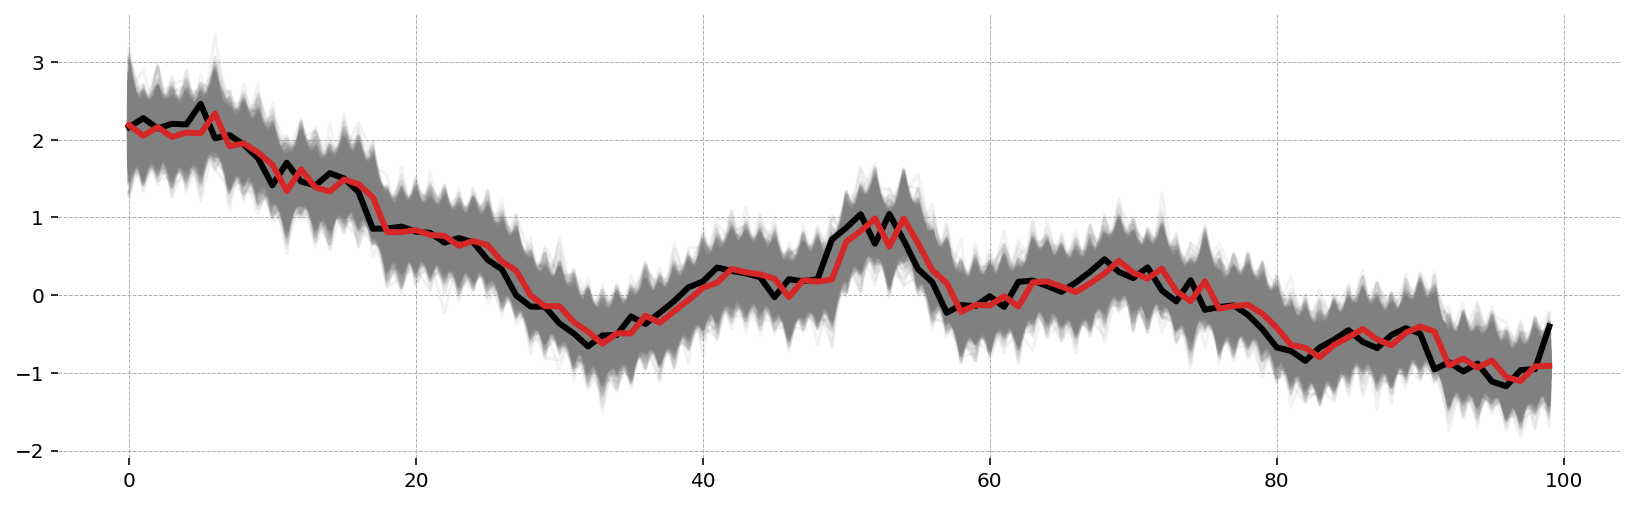

In [ ]:
fig, ax = plt.subplots()
post_cond = idata_conditional.posterior_predictive.y_hat_conditional
mu_cond = post_cond.mean(dim=["chain", "draw"])

ax.plot(data, lw=3, c="k", zorder=100)
ax.plot(mu_cond, lw=3, c="tab:red", zorder=100)
ax.plot(post_cond.stack(sample=["chain", "draw"]).values, c="0.5", alpha=0.1)
plt.show()

# Pause and Recap

We've just crushed through a ton of content in just a few minutes, and we're not even to the main topic of this tutorial. The key take-aways so far are:

1. Time series models can be represented as **time-as-feature** models, which might be linear and fast. These might be all your need for your problem!
2. **Recusrive models** are implemented in PyMC using the `scan` function. It's very general and thus very powerful, but that same generality also gives it a steep learning curve.
3. Using `pm.CustomDist`, you can represent a huge variety of recursive models. We looked at the AR(1), but really the sky is the limit here. Models can include **non-linearities**, and **any distribution**, not just Gaussians.
4. What you get out fom `pm.CustomDist` isn't necessarily what you want. You need to jump through some extra hoops to get the **conditional posterior distribution**. We didn't show how to get forecasts, but that's yet another hoop.

Each time series task presents more hoops -- we didn't cover them all here. By cherry-picking a simple, well-behaved model, I showed the `pm.CustomDist` workflow in the best possible light. When things start to get more complicated, however, it can quickly break down. For example, what if:

- You observe multiple time series?
- The observed state depends on a more complex system of equations?
- There are multiple innovations with some kind of dependency structure between them?
- You have missing data?
- You want to manually specify innovations and study how they propogate through the system?

You can do all this, but you will have to write custom helpers for each and every task. You will likely have to come say hi on the [Discourse forum](https://discourse.pymc.io/) to get help (but please do that anyway!). You will eventually question your sanity.

To spare you from this fate, we now introduce `pymc_extras.statespace`

# Second Verse, Same as the First

We now begin the tutorial that you all came for.

The `statespace` module is designed to make working with recursive time series models easier. It implements many popular time series models, and also gives you access to a huge suite of post-estimation tools. This convenience does, however, come at a cost. Although "statespace" can refer to basically any recursive model of the form $y_t = g(y_{t-1})$, we are now limited to **linear** functions of the form:

$$ x_t = A x_{t-1} + d $$

Where $A$ is a square matrix, and $d$ is a vector of bias terms. I have suggestively changed the letter from $y_t$ to $x_t$ for reasons I decline to reveal right now.

In addition, we are also not free to choose whatever **innovation distributions** we please. We are now restricted to **Gaussian innovations**. For this reason, the class of models we can work with are called **Linear Gaussian Statespace Models**.

All models we can represent in `statespace` are of the form:


$$
\begin{align}
x_t &= A x_{t-1} + c + R \varepsilon_t & \quad \varepsilon_t &\sim N(0, Q) \\
y_t &= Z x_t + d + \eta_t & \quad \eta_t &\sim N(0, H)
\end{align}
$$

Here is a table explaining what all of these objects are. It is copied from an example on [hurricane path prediction using statespace models](https://www.pymc.io/projects/examples/en/latest/case_studies/ssm_hurricane_tracking.html), by Jonathan Dekermanjian:

|State Equation variables|Definition|
| ---------------------- | ---------|
| $T_{t}$ | The state transition matrix at time $t$ defines the kinematics of the process generating the series.|
| $x_{t}$ | The state vector at time $t$ describes the current state of the system.|
| $c_{t}$ | Intercept vector at time $t$ can include covariates/control/exogenous variables that are deterministically measured.|
| $R_{t}$ | Selection matrix at time $t$ selects which process innovations are allowed to affect the next state.|
| $\epsilon_{t}$ | State/Process innovations at time $t$ defines the shocks influencing the changes in the state matrix.|

|Observation Equation variables|Definition|
| ---------------------------- | -------- |
| $Z_{t}$ | The design matrix at time $t$ defines which states directly influence the observed variables. |
| $y_{t}$ | The observed state vector at time $t$ describes the current state of the system, *as we can observe it*. |
| $d_{t}$ | Observation intercept vector at time $t$ can include covariates/control/exogenous variables that are deterministically measured. |
| $\eta_{t}$ | Observation/measurement error at time $t$ defines the uncertainty in the observation. |


## Our first statespace model

Statespace models are a bit odd, and definitely not the same as a normal PyMC model.

You define a statespace in two steps:

1. First, define a statespace model. This is a helper class that knows about the *structure* of the model, but not the specifics.
2. Then, define a PyMC model. This will fill in the scaffoling with specific parameter values.

Model estimation is done in PyMC. Once you have your `idata` object, you can use it to do post-estimation tasks with the statespace model.

Let's make an AR(1) model. To do this, we will use the `BayesianSARIMAX` class. There are many arguments for the class constructor -- check the docs for more details. For our purposes here, three are important:

- `order` determines how many lags our model will have. We want to do an AR(1), so the order should be `(1, 0, 0)`. If you're curious, the last number defines the number of moving average lags, so `(0, 0, 1)` is an MA(1). `(1, 0, 1)` is an ARMA(1, 1). The middle number is for taking differences and is used to define ARIMA models. That's beyond the scope here.

- `stationary_initialization` is a very importantant flag. If True, it makes your life easier by eliminating nuciance parameters, but it also makes your life harder because you have to ensure that your model is stationary! If `False`, you need to specify the initial conditions for the model. To more closely match the first model we did, we will set it to `False` to begin.

- `mode="JAX"` will set all post-estimation tasks to use the JAX computational backend. This is quite important -- these models can be extremely slow otherwise.

In [ ]:
import pymc_extras.statespace as pmss

ar_mod_ss = pmss.BayesianSARIMAX(
    order=(1, 0, 0), stationary_initialization=False, mode="JAX"
)

                            Model Requirements                            
                                                                          
  Variable      Shape    Constraints                          Dimensions  
 ──────────────────────────────────────────────────────────────────────── 
  x0            (1,)                                          ('state',)  
  P0            (1, 1)   Positive Semi-definite   ('state', 'state_aux')  
  ar_params     (1,)     None                                ('lag_ar',)  
  sigma_state   ()       Positive                                   None  
                                                                          
   These parameters should be assigned priors inside a PyMC model block   
            before calling the build_statespace_graph method.             

When you initialize a `PyMCStateSpace` object, you will get a little table like this. This table tells you how to build a PyMC model for this statespace model. We need to define two priors:

- `ar_params` can be anything (because Constraints is `None`), but it needs to have `dims=['lag_ar']`.
- `sigma_state` must be strictly positive, and should not have a dimension (or a shape). That is, `shape = ()` means this parameter is a scalar.

In addition, we have the initial conditions:

- `x0` can be anything, but should have dimension `state`
- `P0` should be Positive Semi-definite! It's a covariance matrix, so we can either make it diagonal and positive, or use an `LKJCholeskyCov`. It should also have two dims: `state` and `state_aux`.

All statespace models have a `coords` property we can use to automatically fill out the expected coordinates.

In [ ]:
with pm.Model(coords=ar_mod_ss.coords) as pymc_mod_ss:
    pm.Normal("x0", sigma=3, dims=["state"])
    pm.HalfNormal("P0", 1, dims=["state", "state_aux"])
    pm.Normal("ar_params", mu=0, sigma=1, dims=["lag_ar"])
    pm.Exponential("sigma_state", 1)

Here I chose to build the PyMC model in an extremely magical and mysterious way: I didn't save any of the parameteres into Python variables. This is just to illustrate that **statespace models work on name matching**. You can have as many things as you want in your PyMC model, but among them, you *must* have `ar_params `and `sigma_state`.

Once you're all set up, you call the `build_statespace_graph` method of the statespace model, passing in the data, inside a PyMC model context

In [ ]:
with pymc_mod_ss:
    # Data has to be 2d, so we insert a dummy index.
    ar_mod_ss.build_statespace_graph(data[:, None])

Once the statespace graph is built, you will see that a new distribution, called `obs`, has been created. It is associated with a `KalmanFilter` distribution. This is the algorithm that is used to work out the likelihood for all Linear Gaussian Statespace models.

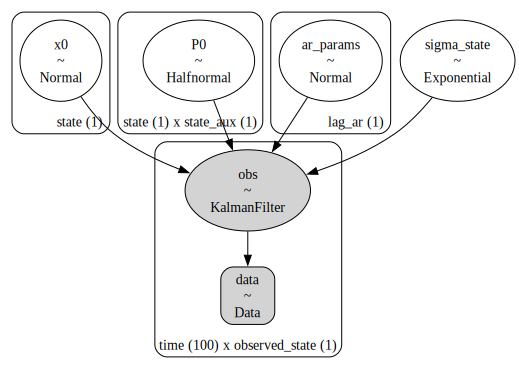

In [ ]:
pymc_mod_ss.to_graphviz()

So now we're ready to sample!

In [ ]:
with pymc_mod_ss:
    idata_ss = pm.sample(
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        random_seed=rng,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,32,0.67,7
,2000,38,0.71,3
,2000,44,0.73,1
,2000,48,0.66,3


## Post-estimation

Now that we have an `idata`, we can do post estimation tasks.

First, we can get the **unconditional posterior**. We do that with the `sample_unconditional_posterior` method

In [ ]:
unconditional_post = ar_mod_ss.sample_unconditional_posterior(idata_ss, random_seed=rng)

Sampling: [posterior_combined]


Output()

In [ ]:
unconditional_post

<xarray.Dataset> Size: 6MB
Dimensions:             (chain: 4, draw: 1000, time: 100, state: 1,
                         observed_state: 1)
Coordinates:
  * chain               (chain) int64 32B 0 1 2 3
  * draw                (draw) int64 8kB 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * time                (time) int64 800B 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
  * state               (state) <U4 16B 'data'
  * observed_state      (observed_state) <U4 16B 'data'
Data variables:
    posterior_latent    (chain, draw, time, state) float64 3MB 3.713 ... -0.5871
    posterior_observed  (chain, draw, time, observed_state) float64 3MB 3.714...
Attributes:
    created_at:                 2025-09-01T07:17:37.230779+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.25.1

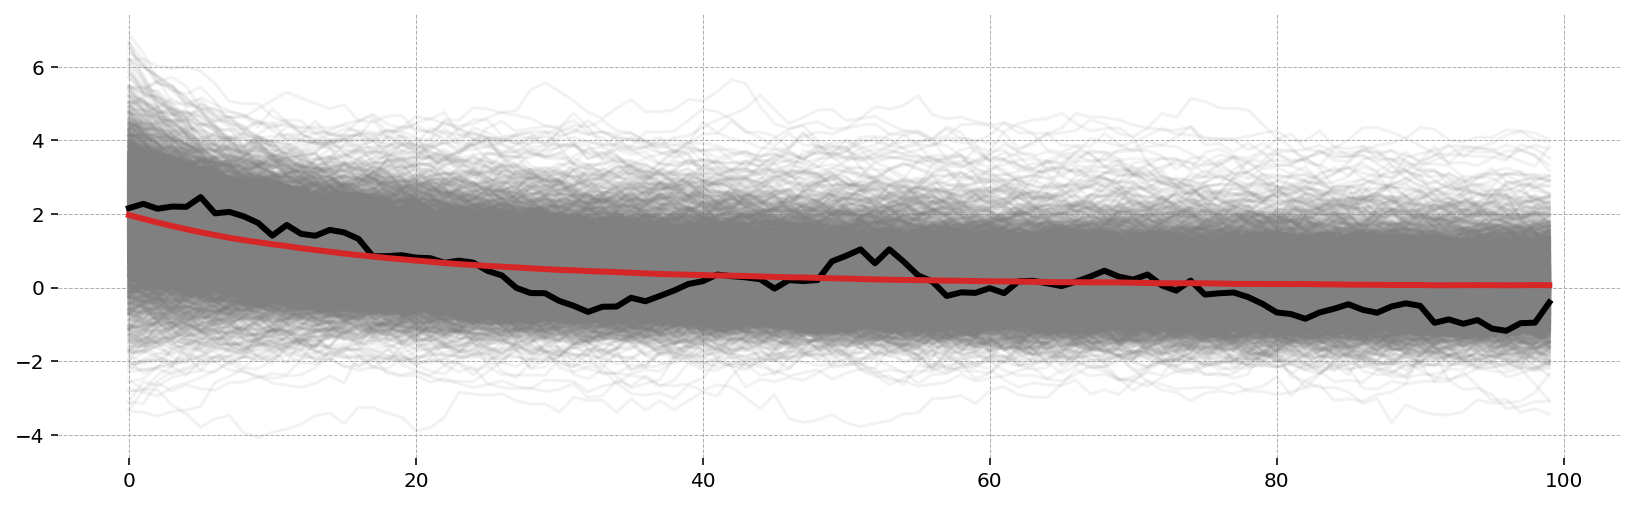

In [ ]:
fig, ax = plt.subplots()
post_uncond = unconditional_post.posterior_observed.isel(observed_state=0).where(
    np.abs(idata_ss.posterior.ar_params.squeeze()) < 1
)
mu_uncond = post_uncond.mean(dim=["chain", "draw"])

ax.plot(data, lw=3, c="k", zorder=100)
ax.plot(mu_uncond, lw=3, c="tab:red", zorder=100)
ax.plot(post_uncond.stack(sample=["chain", "draw"]).values, c="0.5", alpha=0.1)
plt.show()

In [ ]:
conditional_post = ar_mod_ss.sample_conditional_posterior(idata_ss, random_seed=rng)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

In [ ]:
conditional_post

<xarray.Dataset> Size: 19MB
Dimensions:                       (chain: 4, draw: 1000, time: 100, state: 1,
                                   observed_state: 1)
Coordinates:
  * chain                         (chain) int64 32B 0 1 2 3
  * draw                          (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * time                          (time) int64 800B 0 1 2 3 4 ... 95 96 97 98 99
  * state                         (state) <U4 16B 'data'
  * observed_state                (observed_state) <U4 16B 'data'
Data variables:
    filtered_posterior            (chain, draw, time, state) float64 3MB 2.16...
    filtered_posterior_observed   (chain, draw, time, observed_state) float64 3MB ...
    predicted_posterior           (chain, draw, time, state) float64 3MB 1.42...
    predicted_posterior_observed  (chain, draw, time, observed_state) float64 3MB ...
    smoothed_posterior            (chain, draw, time, state) float64 3MB 2.16...
    smoothed_posterior_observed   (chain, draw, time, observed_state) float64 3MB ...
Attributes:
    created_at:                 2025-09-01T07:17:51.674277+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.25.1

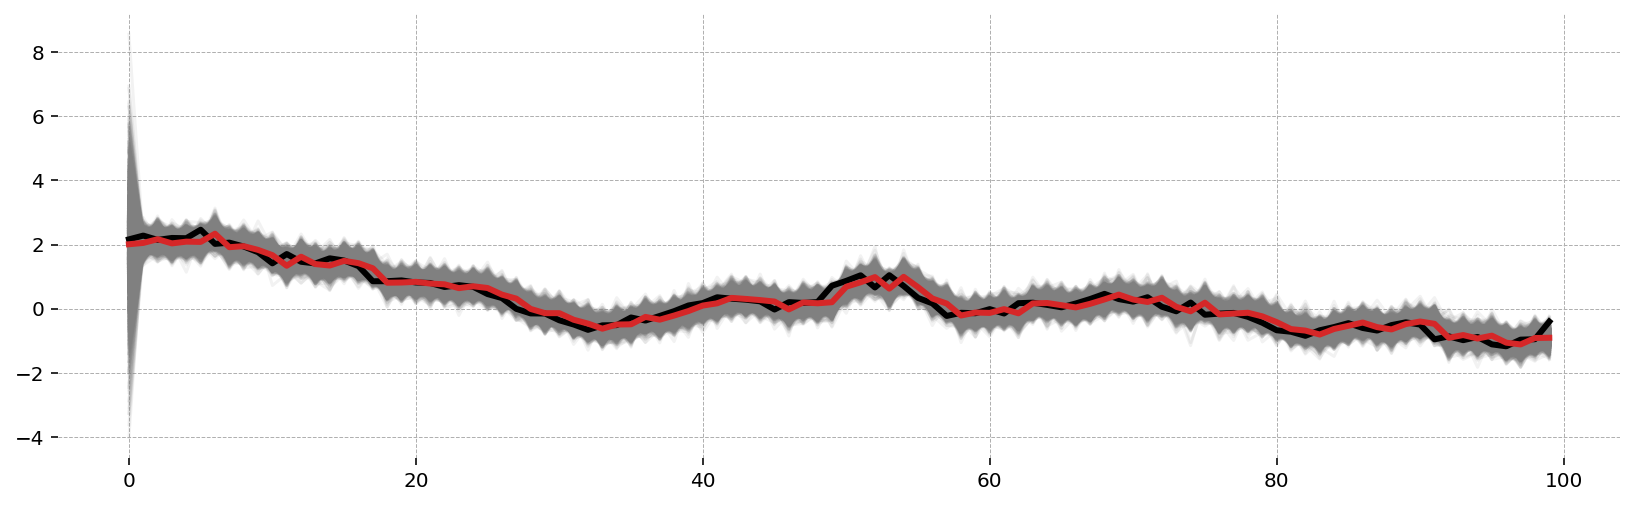

In [ ]:
fig, ax = plt.subplots()
post_cond = conditional_post.predicted_posterior_observed.isel(observed_state=0)
mu_cond = post_cond.mean(dim=["chain", "draw"])

ax.plot(data, lw=3, c="k", zorder=100)
ax.plot(mu_cond, lw=3, c="tab:red", zorder=100)
ax.plot(post_cond.stack(sample=["chain", "draw"]).values, c="0.5", alpha=0.1)
plt.show()

## Forecasting

One of the most important post-estimation tasks is forecasting. To do this, use the `forecast` method!

In [ ]:
forecast_idata = ar_mod_ss.forecast(idata_ss, periods=30, filter_output="predicted")

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]


Output()

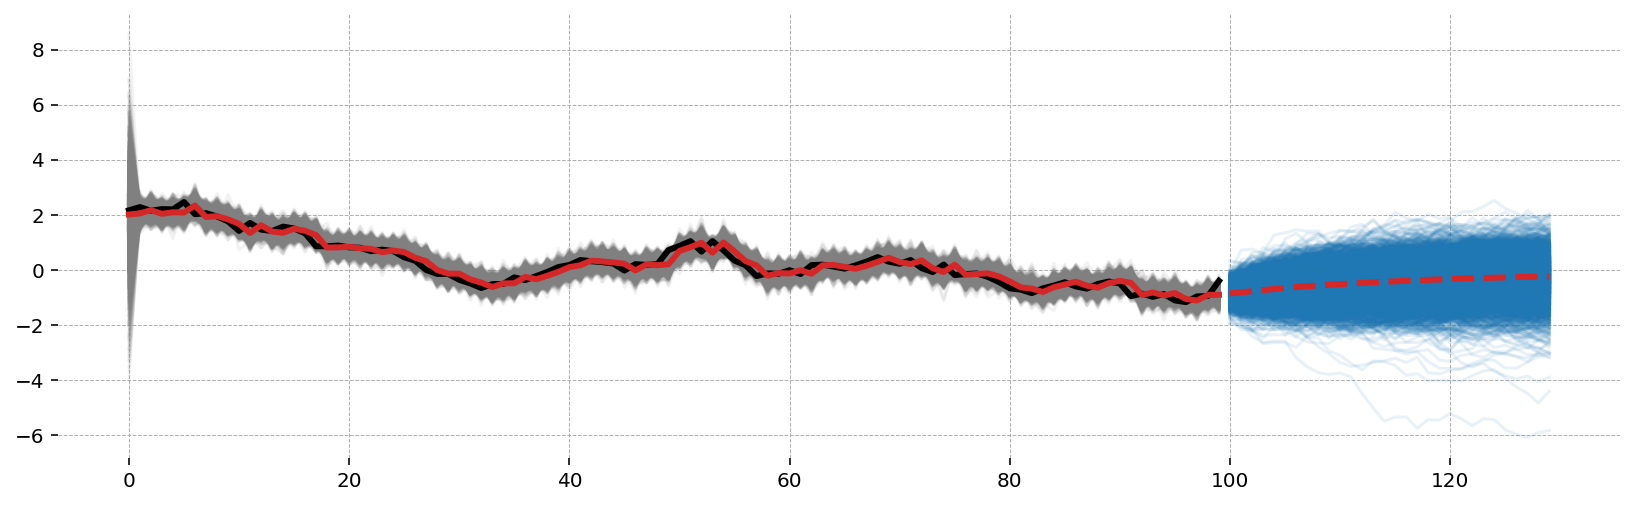

In [ ]:
fig, ax = plt.subplots()
post_cond = conditional_post.predicted_posterior_observed.isel(observed_state=0)
mu_cond = post_cond.mean(dim=["chain", "draw"])

ax.plot(data, lw=3, c="k", zorder=100)
ax.plot(mu_cond, lw=3, c="tab:red", zorder=100)
ax.plot(post_cond.stack(sample=["chain", "draw"]).values, c="0.5", alpha=0.1)

forecast_obs = forecast_idata.forecast_observed.isel(observed_state=0)
forecast_mu = forecast_obs.mean(dim=["chain", "draw"])

ax.plot(range(100, 130), forecast_mu.values, lw=3, color="tab:red", ls="--", zorder=100)
ax.plot(
    range(100, 130),
    forecast_obs.stack(sample=["chain", "draw"]).values,
    color="tab:blue",
    alpha=0.1,
)
plt.show()

# Kalman Filtering

Under the hood, a statspace model is running an algorithm called a Kalman Filter to the probability of data given our dynamical system.

The full details of how the Kalman Filter works is beyond the scope of this tutorial. I recommend the excellent interactive textbook [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) if you're interested to learn more.

For our purposes here, you need to know three things:

1. The Kalman Filter is an iterative algorithm.
2. It has two steps: predict and update.
3. The ultimate purpose is to find a compromise between the dynamics of the system and the observed data.

Here is the picture you should have in your mind, taken Kalman and Bayesian Filters in Python:

![image.png](attachment:image.png)

In our context, the terms *prior* and *posterior* are extremely overloaded. During Kalman Filtering, **the parameters of the model are frozen**. The terms prior and posterior refer to the **hidden states of the system**.

The term **hidden state** is another bit of vocabulary that I want to return to in a moment.

First, to get a better handle on what we get back from the Kalman filter, we need to introduce a new model.

## A simple Newtonian model

To get an intuition for Kalman filtering, it's good to go back to its origins in **object tracking**. Actually, the Kalman Filter was used in the guidance computer for the Apollo 11 Lunar mission. So we're really going back to the original purpose of this algorithm.

Suppose we are tracking the position of an object in 2D space; perhaps a car using GPS. We periodically get position updates. Assume the time delta is quite small, on the order of a few seconds. We are faced with the following data. What is your **best guess** for the next position of the car?

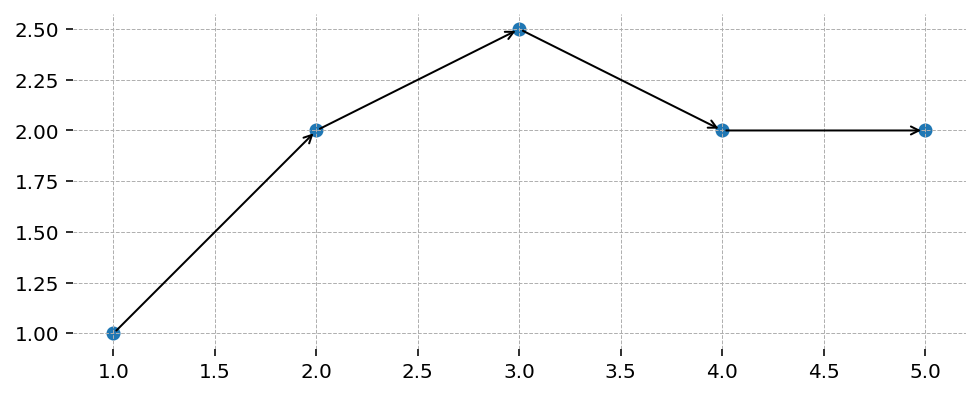

In [ ]:
from itertools import pairwise

fig, ax = plt.subplots(figsize=(8, 8), dpi=144, subplot_kw={"aspect": "equal"})
car_data = np.array([[1.0, 1.0], [2.0, 2.0], [3.0, 2.5], [4.0, 2.0], [5.0, 2.0]])

ax.scatter(*car_data.T)
for t, (xy_init, xy_next) in enumerate(pairwise(car_data)):
    ax.annotate("", xy=xy_next, xytext=xy_init, arrowprops={"arrowstyle": "->"})

You know that cars can't teleport, and also that they usually don't just suddenly turn on a dime. So your best guess is probably that the car will continue on a similar trajectory. This is an inference about the car's **velocity** -- that it will remain roughly constant. Velocity, in turn, is a **hidden state**. We don't observe it, but we assert that it exists, and we form expectations about the evolution of the observed system accordingly.

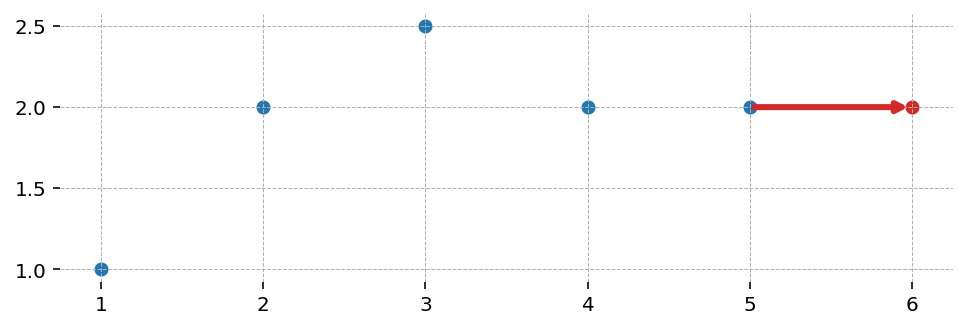

In [ ]:
from itertools import pairwise

fig, ax = plt.subplots(figsize=(8, 8), dpi=144, subplot_kw={"aspect": "equal"})
car_data = np.array(
    [[1.0, 1.0], [2.0, 2.0], [3.0, 2.5], [4.0, 2.0], [5.0, 2.0], [6.0, 2.0]]
)

ax.scatter(*car_data[:-1, :].T)
ax.scatter(*car_data[-1, :].T, c="tab:red")

ax.annotate(
    "",
    xy=[6.0, 2.0],
    xytext=[5.0, 2],
    arrowprops={"arrowstyle": "->", "color": "tab:red", "lw": 3},
)
plt.show()

## Hidden State Inference

The Kalman Filter is primarily a machine for performing **hidden state inference**. Faced with **data** and a **model of the system**, the Kalman Filter gives us the best way to reconsile the two.

Let's continue with the example of object tracking. Suppose we have the following dataset, maybe from a cannonball or something. We track its $(x, y)$ position with some noisy instruments and get the following dataset.

Our main question is, what what the **true** trajectory of the cannonball?

We posit that it's position only changes because it has some underlying velocity. The underlying velocity might also have an (further) underlying acceleration, but we just assume that to be constant.

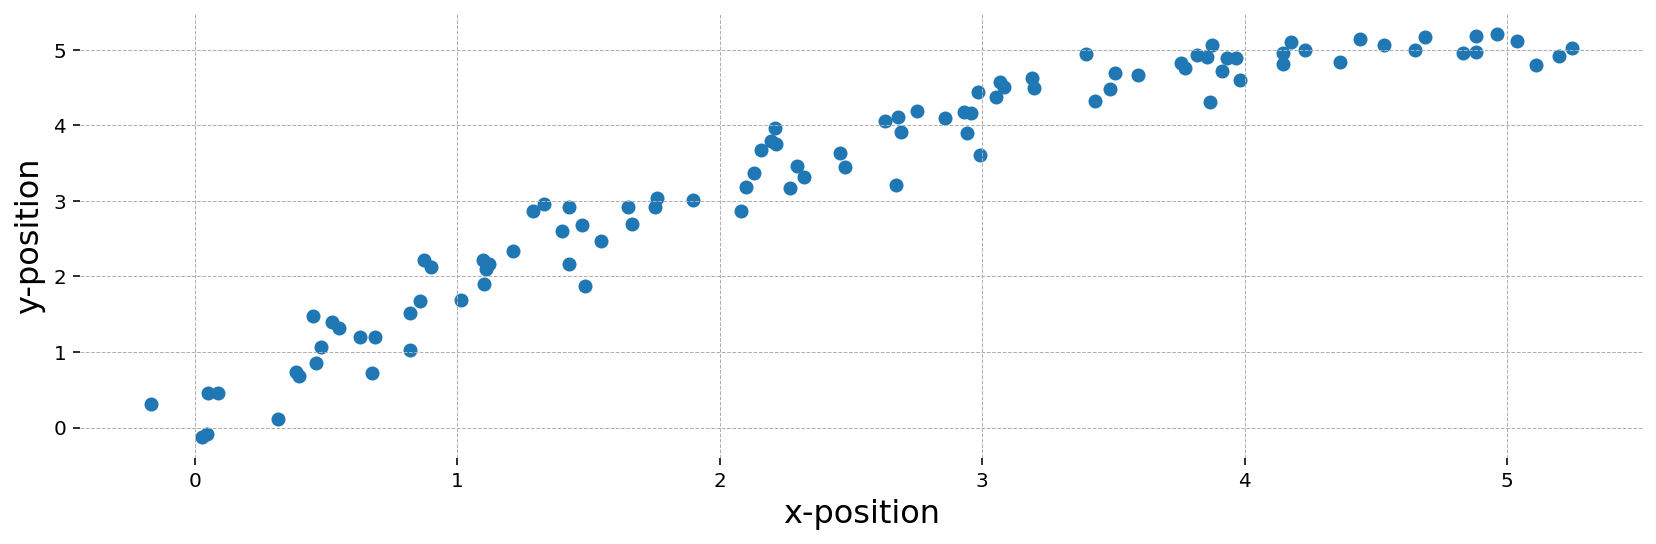

In [ ]:
def trajectory_2d(x0, v0, a, dt=0.01, n_steps=1000):
    t = np.arange(n_steps) * dt

    x = (
        x0
        + np.outer(t, v0)
        + 0.5 * np.outer(t**2, a)
        + np.random.normal(scale=0.2, size=(100, 2))
    )
    return t, x


x0 = [0.0, 0.0]
v0 = [5.0, 10.0]
a = [0.0, -9.81]
t, data = trajectory_2d(x0, v0, a, dt=0.01, n_steps=100)

fig, ax = plt.subplots()
ax.scatter(*data.T)
ax.set_xlabel("x-position", fontsize=16)
ax.set_ylabel("y-position", fontsize=16)
plt.show()

In [ ]:
physical_model = pmss.structural.LevelTrendComponent(
    name="xy",
    order=3,
    innovations_order=[0, 1, 0],
    observed_state_names=["x", "y"],
    share_states=False,
)
measurement_error = pmss.structural.MeasurementError(
    name="xy_error", observed_state_names=["x", "y"], share_states=False
)

physics_mod = (physical_model + measurement_error).build()

                              Model Requirements                               
                                                                               
  Variable         Shape    Constraints                            Dimensions  
 ───────────────────────────────────────────────────────────────────────────── 
  initial_xy       (2, 3)                            ('endog_xy', 'state_xy')  
  sigma_xy         (2, 1)   Positive                 ('endog_xy', 'shock_xy')  
  sigma_xy_error   (2,)     Positive                      ('endog_xy_error',)  
  P0               (6, 6)   Positive semi-definite     ('state', 'state_aux')  
                                                                               
  These parameters should be assigned priors inside a PyMC model block before  
                  calling the build_statespace_graph method.                   

In [ ]:
with pm.Model(coords=physics_mod.coords) as pymc_physics_mod:
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=1, dims=["state"])
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=["state", "state_aux"])
    initial_xy = pm.Normal(
        "initial_xy", [0.0, 10.0, 0.0], sigma=3, dims=["endog_xy", "state_xy"]
    )
    sigma_xy = pm.HalfNormal("sigma_xy", 1.0, dims=["endog_xy", "shock_xy"])
    sigma_xy_error = pm.HalfNormal("sigma_xy_error", 1.0, dims=["endog_xy_error"])

    physics_mod.build_statespace_graph(data)
    idata = pm.sample(
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
        chains=6,
        draws=500,
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,2,0.56,7
,1500,8,0.58,7
,1500,11,0.52,7
,1500,9,0.54,7
,1500,3,0.54,7
,1500,8,0.54,7


In [ ]:
post_cond = physics_mod.sample_conditional_posterior(idata, mvn_method="cholesky")

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

In [ ]:
post_cond.data_vars

Data variables:
    filtered_posterior            (chain, draw, time, state) float64 14MB 0.1...
    filtered_posterior_observed   (chain, draw, time, observed_state) float64 5MB ...
    predicted_posterior           (chain, draw, time, state) float64 14MB 1.2...
    predicted_posterior_observed  (chain, draw, time, observed_state) float64 5MB ...
    smoothed_posterior            (chain, draw, time, state) float64 14MB -0....
    smoothed_posterior_observed   (chain, draw, time, observed_state) float64 5MB ...

Once we sample the model (to get an `idata`) and sample the conditional posterior states, we get back a new `az.InfereceData` with 6 groups:

- 3 are hidden states: filtered_posterior, predicted_posterior, smoothed_posterior
- 3 are observed states: filtered_posterior_observed, predicted_posterior_observed, smoothed_posterior_observed

Likewise, these 6 can also be split into three *types* of outputs: **filtered**, **predicted** and **smoothed**.

We have already seen the **predicted** outputs. These are the one-step ahead predictions of the model given data. In the AR(1) case, it was $y_t = \rho y_{t-1}$. In our new case, it's going to take the last observed position of the cannonball and apply the kinematic equations, updating *both* the x and y coordinates. **Importantly**, the prediction doesn't know anything about the data for the cannonball at time $t$ !

The **filtered** outputs, on the other hand, do get to see the data a time $t$. The filter asks: given the model,  our faith in the measuring devices, and the latest measurements, where do we think the cannonball really is? This is sometimes written as $y_{t|t}$, because it's out guess for the **true** state of the system at time $t$, given that we've seen data at time $t$.

Finally, the **smoothed** outputs go one step further. Having seen all available data -- the entire history of the cannonball's flight -- can we then go backwards and improve our hidden state inference? The answer is usually yes. We further refine our estimate of the hidden states by going backwards, considering where the cannonball probably *was*, given that we already know where it is *going to go*.

### Visualize the outputs

The first output we care about it the "top level" result -- what was the true position of the cannonball?

Here we see some important characteristics of the Kalman Filter:

1. There is a "burn-in period" where the filter is trying to learn the dynamics of the system
2. As data comes in, the filter performance improves, and converges to something reasonable
3. The Smoother goes back and fixes this burn-in error. The black line is a nice smooth arc, even in the beginning where the orange and red lines are nonsense.

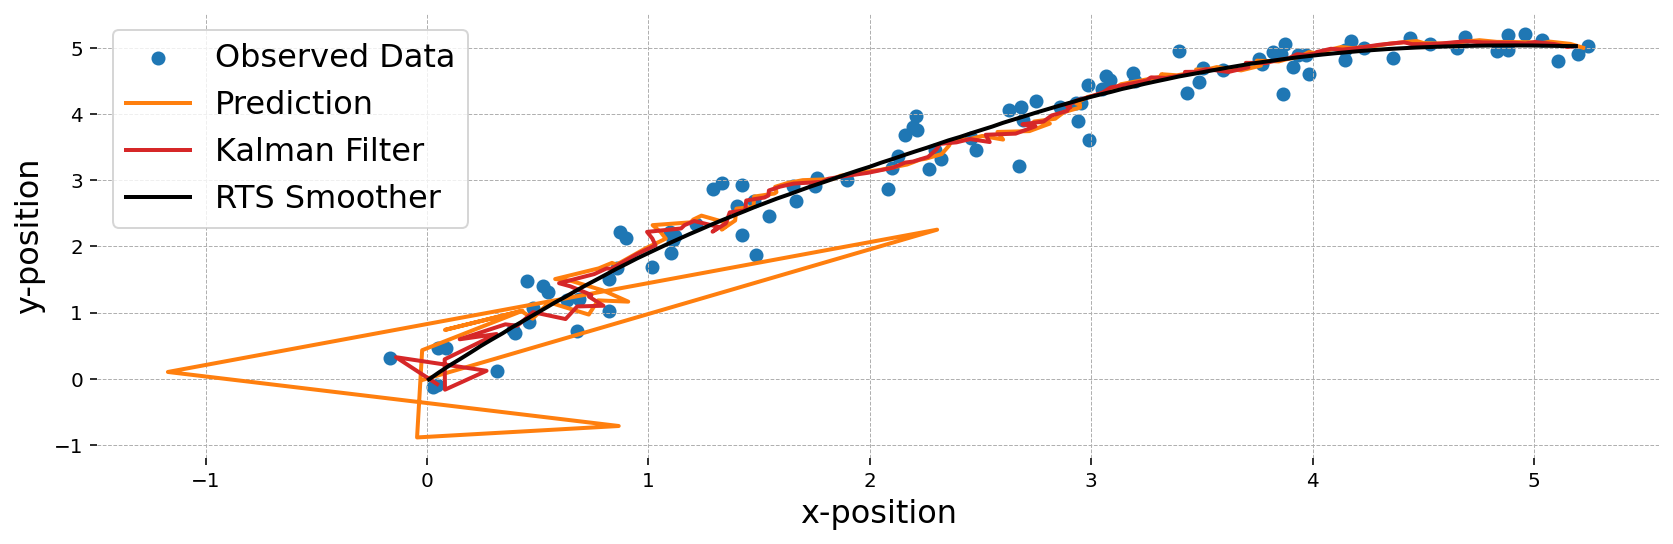

In [ ]:
fig, ax = plt.subplots()

xy_predicted_hat = post_cond.predicted_posterior.sel(state=["level[x]", "level[y]"])
xy_filtered_hat = post_cond.filtered_posterior.sel(state=["level[x]", "level[y]"])
xy_smoothed_hat = post_cond.smoothed_posterior.sel(state=["level[x]", "level[y]"])

ax.scatter(*data.T, label="Observed Data")

ax.plot(
    *xy_predicted_hat.mean(dim=["chain", "draw"]).values.T,
    color="tab:orange",
    lw=2,
    label="Prediction"
)
ax.plot(
    *xy_filtered_hat.mean(dim=["chain", "draw"]).values.T,
    color="tab:red",
    lw=2,
    label="Kalman Filter"
)
ax.plot(
    *xy_smoothed_hat.mean(dim=["chain", "draw"]).values.T,
    color="k",
    lw=2,
    label="RTS Smoother"
)
ax.set_xlabel("x-position", fontsize=16)
ax.set_ylabel("y-position", fontsize=16)
ax.legend(fontsize=16)
plt.show()

### Hidden States

We also infer the velocity (which changes over time) and the constant acceleration. We can look at the smoothed versions of these

Text(0, 0.5, 'y-direction velocity')

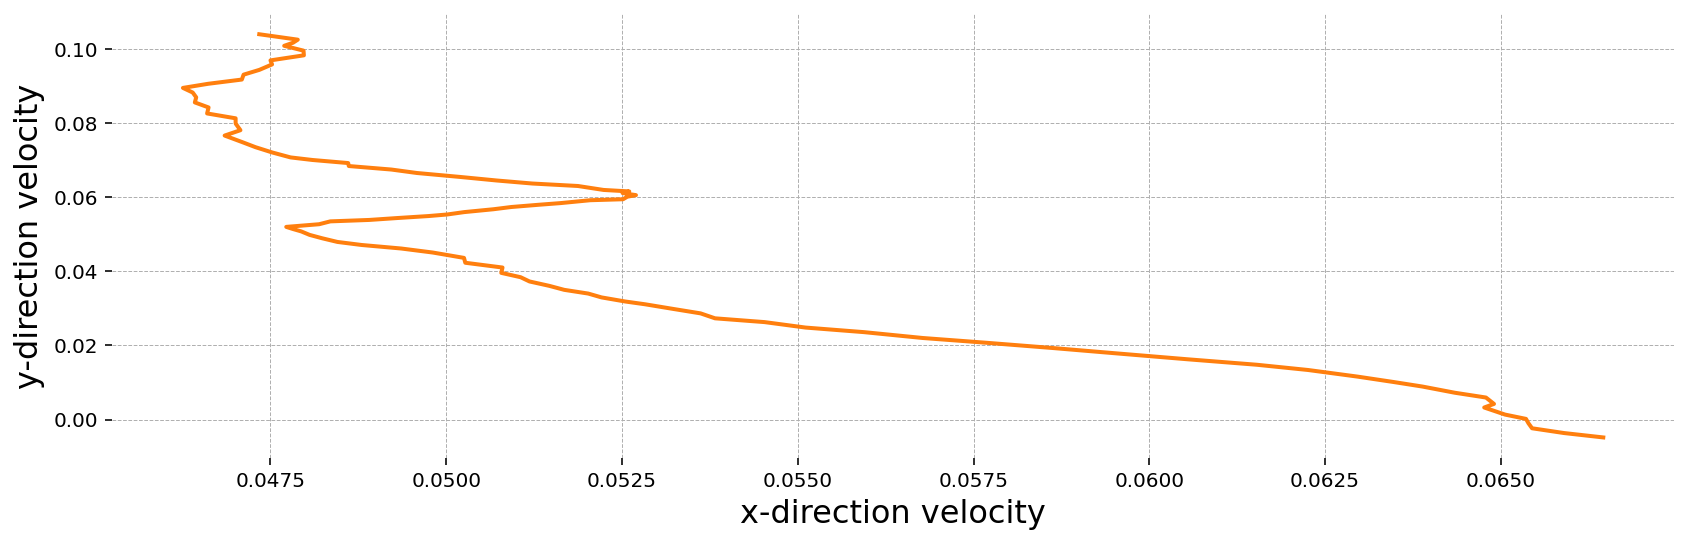

In [ ]:
fig, ax = plt.subplots()

xy_smoothed_hat = post_cond.smoothed_posterior.sel(state=["trend[x]", "trend[y]"])
ax.plot(
    *xy_smoothed_hat.mean(dim=["chain", "draw"]).values.T,
    color="tab:orange",
    lw=2,
    label="Velocity"
)
ax.set_xlabel("x-direction velocity", fontsize=16)
ax.set_ylabel("y-direction velocity", fontsize=16);

Text(0, 0.5, 'y-direction acceleration')

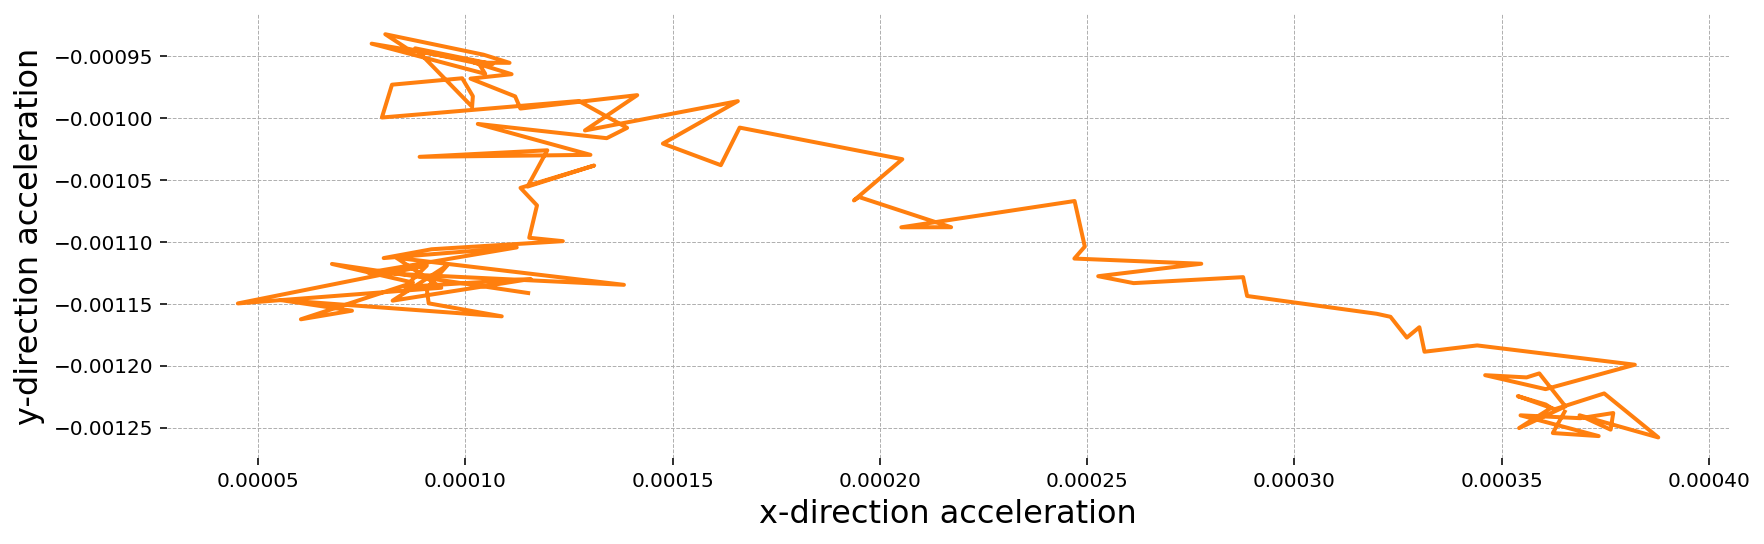

In [ ]:
fig, ax = plt.subplots()

xy_smoothed_hat = post_cond.smoothed_posterior.sel(
    state=["acceleration[x]", "acceleration[y]"]
)
ax.plot(
    *xy_smoothed_hat.mean(dim=["chain", "draw"]).values.T,
    color="tab:orange",
    lw=2,
    label="Velocity"
)
ax.set_xlabel("x-direction acceleration", fontsize=16)
ax.set_ylabel("y-direction acceleration", fontsize=16);

In [ ]:
%load_ext watermark

%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Sep 01 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

numpy     : 2.2.6
pytensor  : 2.31.7
pymc      : 5.25.1
arviz     : 0.22.0
matplotlib: 3.10.5

Watermark: 2.5.0

